# GARCH

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [64]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [65]:
%ripl --seed 10000

Set seed of a new VentureScript RIPL to 10000.00.


## GARCH(1, 1)
(not sure what a good priosr are for this one.

$\sigma_0 = \text{gamma}(1,1)$

$\alpha_0 = \text{gamma}(1,1)$

$\alpha_1 = \text{gamma}(1,1)$

$\beta_1  = \text{gamma}(1,1)$

(Edit: gamma was replace by gradient safe exponential prior emulating `gamma(1,1)`)

### Process model:
$\sigma_t^2 =  \alpha_0  + \alpha_1 \epsilon_{t-1}^2 + \beta_1\sigma_{t-1}^2$

$\epsilon_t \sim N(0, \sigma_t$)


In [66]:
%%venturescript
assume alpha_0 = 5;
assume alpha_1 = 2;
assume beta_1  = 0.3;
assume sigma_squared_0 = 0.4;

In [67]:
%%venturescript
assume sigma_squared = (t) -> {
    if (t==0) {
        sigma_squared_0
    } else {
        alpha_0 + alpha_1 * (epsilon(t-1)**2) + beta_1 * sigma_squared(t-1)
    }
};
assume epsilon = mem((t) -> {
    normal(0, sqrt(sigma_squared(t)))
});

In [68]:
%%venturescript
define n = 100


100.0

In [69]:
%%venturescript
for_each(
    arange(n),
    (i) -> {predict epsilon($i);}
);

In [70]:
%%venturescript
sample sigma_squared(1)

5.244057314189199

In [71]:
%%venturescript 
assume all_data  = mapv((t) -> {epsilon(t)}, arange($n));

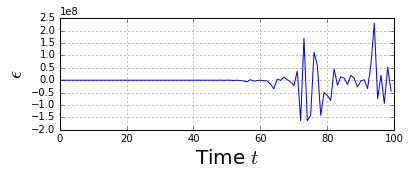

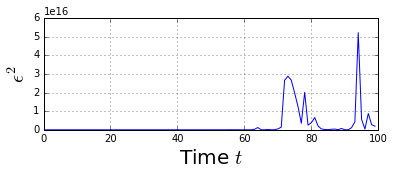

In [72]:
all_data = %venturescript sample all_data
n = %venturescript n
n_training = int(0.8 * n)

all_data = np.asarray(all_data)
width = 6
height = 2
fig, ax = plt.subplots()
ax.plot(all_data);
ax.grid(True)
ax.set_xlabel('Time $t$', fontsize=20)
ax.set_ylabel('$\epsilon$', fontsize=20)
fig.set_size_inches(width, height)
fig, ax = plt.subplots()
ax.plot(all_data**2);
ax.grid(True)
ax.set_xlabel('Time $t$', fontsize=20)
ax.set_ylabel('$\epsilon^2$', fontsize=20)
fig.set_size_inches(width, height)
np.savetxt('training_data.csv', all_data[:n_training])
np.savetxt('test_data.csv', all_data[n_training:])

## 1. Venture model component

In [52]:
%ripl --seed 1 --plugins plugins.py

Set seed of a new VentureScript RIPL to 1.00.
Loading plugin: plugins.py


### visualize prior

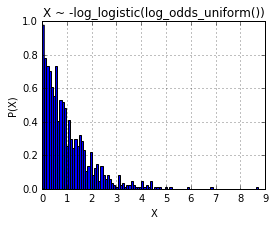

In [46]:
samples = []
for i in range(1000):
    s = %venturescript -log_logistic(log_odds_uniform())
    samples.append(s)
fig, ax = plt.subplots()
ax.hist(samples, bins=100, normed=True);
ax.set_xlabel('X')
ax.set_ylabel('P(X)')
ax.set_title('X ~ -log_logistic(log_odds_uniform())');
fig.set_size_inches(4,3)
ax.grid(True)

In [53]:
%%venturescript
// MODEL
assume alpha_0         =  -log_logistic(log_odds_uniform()) #parameters:0;
//assume alpha_1         =  -log_logistic(log_odds_uniform()) #parameters:1;
//assume beta_1          =  -log_logistic(log_odds_uniform()) #parameters:2;
//assume sigma_squared_0 =  -log_logistic(log_odds_uniform()) #parameters:3;
assume alpha_1 = 0.5;
assume beta_1  = 0.3;
assume sigma_squared_0 = 0.4;
assume sigma_squared = (t) -> {
    if (t==0) {
        sigma_squared_0
    } else {
        alpha_0 + alpha_1 * (epsilon(t-1)**2) + beta_1 * sigma_squared(t-1)
    }
};
assume epsilon = mem((t) -> {
    normal(0, sqrt(sigma_squared(t)))
});
// Next, load data
define training_data = load_csv(str_concat(get_path(),"/training_data.csv"));

## 3. Venture observation component

In [54]:
%%venturescript
// OBSERVATIONS
for_each(
    arange(size(training_data)),
    (i) -> {
        observe epsilon($i) = training_data[i];
    }
);

## 4. Venture infererence components

In [ ]:
%%venturescript
// INFERENCE
define single_site_mh  = () -> {
    mh(default, one, 1)
};
define resimulation_mh  = () -> {
    mh(default, all, 1)
};

In [55]:
%%venturescript
sample alpha_0

2.7966517691743995

In [56]:
%%venturescript
sample alpha_1

0.5

In [57]:
%%venturescript
sample beta_1

0.3

In [58]:
%%venturescript
sample sigma_squared_0

0.4

In [59]:
%%venturescript
lbfgs_optimize(quote(parameters), all)

[37450.0]

### True parameters:
```
%%venturescript
assume alpha_0 = 1;
assume alpha_1 = 0.5;
assume beta_1  = 0.3;
assume sigma_squared_0 = 0.4;```

In [60]:
%%venturescript
sample alpha_0

2.1356711497327794

In [ ]:
%%venturescript
sample alpha_1

In [ ]:
%%venturescript
sample beta_1

In [ ]:
%%venturescript
sample sigma_squared_0

## 5. Execute inference programs and plot results

In [ ]:
def plot_params(n, prior=True):
    samples_alpha_0 = []
    samples_alpha_1 = []
    samples_beta_1 =  []
    for _ in range(n):
        a0 = %venturescript sample alpha_0
        a1 = %venturescript sample alpha_1
        b1 = %venturescript sample alpha_1
        samples_alpha_0.append(a0)
        samples_alpha_1.append(a1)
        samples_beta_1.append(b1)
    return samples_alpha_0, samples_alpha_1, samples_beta_1

In [ ]:
samples_alpha_0, samples_alpha_1, samples_beta_1 = plot_params(100)

In [ ]:
fig, axes = plt.subplots(ncols=3)
axes[0].hist(samples_alpha_0)
axes[1].hist(samples_alpha_1)
axes[2].hist(samples_beta_1)
axes[0].axvline(x=0.2, zorder=3, color='red')
axes[1].axvline(x=0.5, zorder=3, color='red')
axes[2].axvline(x=0.3, zorder=3, color='red')
fig.suptitle('Prior')
fig.set_size_inches(9, 3)

In [ ]:
%%venturescript
mh(default, one, 100)

In [ ]:
samples_alpha_0, samples_alpha_1, samples_beta_1 = plot_params(100, prior=False)

In [ ]:
fig, axes = plt.subplots(ncols=3)
axes[0].hist(samples_alpha_0)
axes[1].hist(samples_alpha_1)
axes[2].hist(samples_beta_1)
axes[0].axvline(x=0.2, zorder=3, color='red')
axes[1].axvline(x=0.5, zorder=3, color='red')
axes[2].axvline(x=0.3, zorder=3, color='red')
fig.suptitle('Posterior')
fig.set_size_inches(9, 3)